*Copyright (c) Microsoft Corporation. All rights reserved.*

*Licensed under the MIT License.*

# Sentiment Analysis and the Unified Information Explainer

# Before You Start

> **Tip**: If you want to run through the notebook quickly, you can set the **`QUICK_RUN`** flag in the cell below to **`True`**. This will run the notebook on a small subset of the data and a use a smaller number of epochs. 

If you run into CUDA out-of-memory error or the jupyter kernel dies constantly, try reducing the `BATCH_SIZE` and `MAX_LEN`, but note that model performance will be compromised. 

In [1]:
## Set QUICK_RUN = True to run the notebook on a small subset of data and a smaller number of epochs.
QUICK_RUN = False

In [2]:
import sys
sys.path.append("../../")
import os
import json
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import nlp

import torch
import torch.nn as nn

from interpret_text.experimental.common.utils_bert import Language, Tokenizer, BERTSequenceClassifier
from interpret_text.experimental.unified_information import UnifiedInformationExplainer
from interpret_text.experimental.common.timer import Timer



## Introduction
In this notebook, we fine-tune and evaluate a pretrained [BERT](https://arxiv.org/abs/1810.04805) model on a subset of the [Emo](https://huggingface.co/datasets/emo/) dataset.

We use a [sequence classifier](https://github.com/microsoft/nlp/blob/master/utils_nlp/models/bert/sequence_classification.py) that wraps [Hugging Face's PyTorch implementation](https://github.com/huggingface/pytorch-pretrained-BERT) of Google's [BERT](https://github.com/google-research/bert).

We then show how to use the [interpret-text](https://github.com/interpretml/interpret-text) package to explain the outcome of the model. More example notebooks and NLP explainer models can be found on the [github page](https://github.com/interpretml/interpret-text).

### Set parameters
First we set some parameters that we use for our modeling task.

In [3]:
TEST_DATA_FRACTION = 1
NUM_EPOCHS = 1

if QUICK_RUN:
    TRAIN_DATA_FRACTION = 0.01
    TEST_DATA_FRACTION = 0.01
    NUM_EPOCHS = 1

if torch.cuda.is_available():
    BATCH_SIZE = 1
else:
    BATCH_SIZE = 2

DATA_FOLDER = "./temp"
BERT_CACHE_DIR = "./temp"
LANGUAGE = Language.ENGLISH
TO_LOWER = True
MAX_LEN = 150
BATCH_SIZE_PRED = 2
TRAIN_SIZE = 0.6
EMOTION_COL = "emotion"
LABEL_COL = "label"
TEXT_COL = "text"

## Read Dataset
We then load the data.

In this dataset, given a textual dialogue i.e. an utterance along with two previous turns of context, the goal was to infer the underlying emotion of the utterance by choosing from four emotion classes - Happy, Sad, Angry and Others.

The Emo dataset is mainly used for sentiment analysis task, where the input is a textual dialogue and the labels are underlying emtion of the dialogue. Given the input, the goal is to identify this underlying emotion from four classes - *happy, sad, angry and others.*

For our classification task, we use three of the classes - happy, sad, angry. 

In [4]:
train, test = nlp.load_dataset("emo", split = ["train", "test"])

In [5]:
id2label = {0: 'others', 1: 'happy', 2: 'sad', 3: 'angry'}
labels=list(id2label.values())
label2id = {}
for i,label in enumerate(labels):
    label2id[label]=i

In [6]:
train_data={TEXT_COL:[],
     EMOTION_COL:[]}
for val in train:
    if id2label[val[LABEL_COL]]!='others':
        train_data[TEXT_COL].append(val[TEXT_COL])
        train_data[EMOTION_COL].append(id2label[val[LABEL_COL]])
        
train_data = pd.DataFrame(train_data)

In [7]:
test_data={TEXT_COL:[],
     EMOTION_COL:[]}
for val in test:
    if id2label[val[LABEL_COL]]!='others':
        test_data[TEXT_COL].append(val[TEXT_COL])
        test_data[EMOTION_COL].append(id2label[val[LABEL_COL]])
        
test_data = pd.DataFrame(test_data)

In [8]:
#Encode labels
label_encoder = LabelEncoder()
train_data[LABEL_COL] = label_encoder.fit_transform(train_data[EMOTION_COL])
test_data[LABEL_COL] = label_encoder.transform(test_data[EMOTION_COL])

## Distribution of Emotion labels

The dataset has three emotions. Here is the distribution in the training and test set:

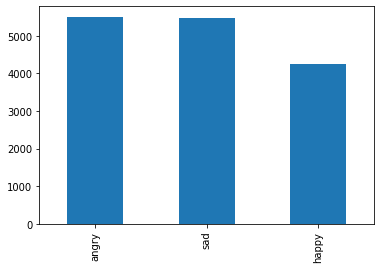

In [9]:
ax = train_data.emotion.value_counts().plot.bar()

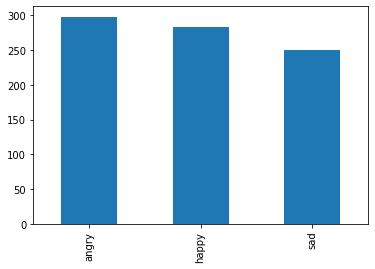

In [10]:
ax = test_data.emotion.value_counts().plot.bar()

In [11]:
train_data[EMOTION_COL].value_counts()

angry    5506
sad      5463
happy    4243
Name: emotion, dtype: int64

In [12]:
test_data[EMOTION_COL].value_counts()

angry    298
happy    284
sad      250
Name: emotion, dtype: int64

In [13]:
print("Number of training examples: {}".format(train_data.shape[0]))
print("Number of testing examples: {}".format(test_data.shape[0]))

Number of training examples: 15212
Number of testing examples: 832


## Tokenize and Preprocess

Before we start training, we tokenize the text documents and convert them to lists of tokens. The following steps instantiate a `BERT tokenizer` given the language, and tokenize the text of the training and testing sets.

In [ ]:
device = torch.device("cpu")# if not torch.cuda.is_available() else "cuda")

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
device

device(type='cpu')

In [16]:
tokenizer = Tokenizer(LANGUAGE, to_lower=TO_LOWER, cache_dir=BERT_CACHE_DIR)

tokens_train = tokenizer.tokenize(list(train_data[TEXT_COL]))
tokens_test = tokenizer.tokenize(list(test_data[TEXT_COL]))

100%|██████████████████████████████████████████████████████████████████████████████| 832/832 [00:00<00:00, 1201.42it/s]


In addition, we perform the following preprocessing steps in the cell below:
- Convert the tokens into token indices corresponding to the BERT tokenizer's vocabulary
- Add the special tokens [CLS] and [SEP] to mark the beginning and end of a sentence, respectively
- Pad or truncate the token lists to the specified max length. In this case, `MAX_LEN = 150`
- Return mask lists that indicate the paddings' positions
- Return token type id lists that indicate which sentence the tokens belong to (not needed for one-sequence classification)

*See the original [implementation](https://github.com/google-research/bert/blob/master/run_classifier.py) for more information on BERT's input format.*

In [17]:
tokens_train, mask_train, _ = tokenizer.preprocess_classification_tokens(tokens_train, MAX_LEN)
tokens_test, mask_test, _ = tokenizer.preprocess_classification_tokens(tokens_test, MAX_LEN)

## Sequence Classifier Model
Next, we use a sequence classifier that loads a pre-trained BERT model, given the language and number of labels.

In [18]:
classifier = BERTSequenceClassifier(language=LANGUAGE, num_labels=3, cache_dir=BERT_CACHE_DIR)

In [19]:
classifier.model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

## Train Model
We train the classifier using the training set. This involves fine-tuning the BERT Transformer and learning a linear classification layer on top of that:

In [20]:
with Timer() as t:
    classifier.fit(token_ids=tokens_train,
                    input_mask=mask_train,
                    labels=train_data[LABEL_COL],    
                    num_epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,    
                    verbose=True)
   
print("[Training time: {:.3f} hrs]".format(t.interval / 3600))

t_total value of -1 results in schedule not being applied
Iteration:   0%|                                                                              | 0/7606 [00:00<?, ?it/s]c:\users\jamahaja\miniconda3\envs\myenv\lib\site-packages\pytorch_pretrained_bert\optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  next_m.mul_(beta1).add_(1 - beta1, grad)
Iteration: 100%|█████████████████████████████████████████████████████████████████| 7606/7606 [6:18:38<00:00,  2.99s/it]

[Training time: 6.311 hrs]


## Score Model
We score the test set using the trained classifier:

In [25]:
preds = classifier.predict(token_ids=tokens_test, 
                           input_mask=mask_test, 
                           batch_size=BATCH_SIZE_PRED)

Iteration: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [03:35<00:00, 107.79s/it]


## Evaluate Model
Finally, we compute the overall accuracy, precision, recall, and F1 metrics on the test set. We also look at the metrics for eact of the genres in the the dataset. 

In [26]:
report = classification_report(test_data[LABEL_COL], preds, target_names=label_encoder.classes_, output_dict=True) 
accuracy = accuracy_score(test_data[LABEL_COL], preds)
print("accuracy: {}".format(accuracy))
print(json.dumps(report, indent=4, sort_keys=True))

accuracy: 0.9170673076923077
{
    "accuracy": 0.9170673076923077,
    "angry": {
        "f1-score": 0.9218241042345278,
        "precision": 0.8955696202531646,
        "recall": 0.9496644295302014,
        "support": 298
    },
    "happy": {
        "f1-score": 0.9355932203389831,
        "precision": 0.9019607843137255,
        "recall": 0.971830985915493,
        "support": 284
    },
    "macro avg": {
        "f1-score": 0.9147912821042138,
        "precision": 0.9229863253318205,
        "recall": 0.9124984718152315,
        "support": 832
    },
    "sad": {
        "f1-score": 0.8869565217391304,
        "precision": 0.9714285714285714,
        "recall": 0.816,
        "support": 250
    },
    "weighted avg": {
        "f1-score": 0.9160471010492105,
        "precision": 0.9205453755260625,
        "recall": 0.9170673076923077,
        "support": 832
    }
}


## Explain Model

In [27]:
device = torch.device("cpu")# if not torch.cuda.is_available() else "cuda")
#download the trained model
classifier.model.to(device)
for param in classifier.model.parameters():
    param.requires_grad = False
classifier.model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [28]:
interpreter_unified = UnifiedInformationExplainer(model=classifier.model, 
                                 train_dataset=list(train_data[TEXT_COL]), 
                                 device=device, 
                                 target_layer=14,
                                classes=label_encoder.classes_)

In [29]:
idx = 3
text = test_data[TEXT_COL][idx]
true_label = label_encoder.inverse_transform([test_data[LABEL_COL][idx]])
predicted_label = label_encoder.inverse_transform([preds[idx]])
print(text, '; true label:', true_label,'; predicted label:', predicted_label)

is my grammar perfect or should i need to learn more yes it is possible thank you ; true label: ['happy'] ; predicted label: ['happy']


In [30]:
explanation_unified = interpreter_unified.explain_local(text, 'happy')

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [02:12<00:00,  1.13it/s]


## Visualize Explanation

In [31]:
from interpret_text.experimental.widget import ExplanationDashboard

In [32]:
ExplanationDashboard(explanation_unified)

ExplanationWidget(value={'text': ['is', 'my', 'grammar', 'perfect', 'or', 'should', 'i', 'need', 'to', 'learn'…